# CAB420, DCNNs, Example 2: Regression with Deep Learning
Dr Simon Denman (s.denman@qut.edu.au)

## Overview

In this example we will:

* Train a deep network for regression
* Look at the difference between a regression task and classification task in terms of network structure
* Use a different activation function (swish) because we can
 
## Too Long; Didn't Read:

The main take home messages from this example are:

* Deep nets can do regression. The only major difference between a network that does classification and regression are the final layer, the loss function, and the structure of the data (in particular the labels).
* We can, if we want, regress to multiple response variables.
* While we can plot residuals, qqplots and similar make little sense here. We're no longer constrained by assumptions on residual distributions, but this makes determining model validity harder. As such, validation data is really important.
* We can, in some cases, refactor classification tasks as regression tasks, though this often does not make sense.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import datetime
import numpy

import keras
from keras import layers

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import cv2

## The Data

We need to a bit of work to create our dataset here. I'm going to replicate an example from MATLAB that tries to regress the angle at which an image of a number has been rotated. To do this, we need a few functions to generate a rotated verison of the data.

In the grand traditions of code re-use, these have been adapted from on-line sources.

In [2]:
def rotate(image, angle):
    """
    Rotates an OpenCV 2 / NumPy image about it's centre by the given angle
    (in degrees). The returned image will be large enough to hold the entire
    new image, with a black background
    Source: http://stackoverflow.com/questions/16702966/rotate-image-and-crop-out-black-borders
    """
    # Get the image size
    image_size = (image.shape[1], image.shape[0])
    image_center = tuple(numpy.array(image_size) / 2)

    # Convert the OpenCV 3x2 rotation matrix to 3x3
    rot_mat = numpy.vstack(
        [cv2.getRotationMatrix2D(image_center, angle, 1.0), [0, 0, 1]]
    )

    rot_mat_notranslate = numpy.matrix(rot_mat[0:2, 0:2])

    # Shorthand for below calcs
    image_w2 = image_size[0] * 0.5
    image_h2 = image_size[1] * 0.5

    # Obtain the rotated coordinates of the image corners
    rotated_coords = [
        (numpy.array([-image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (numpy.array([ image_w2,  image_h2]) * rot_mat_notranslate).A[0],
        (numpy.array([-image_w2, -image_h2]) * rot_mat_notranslate).A[0],
        (numpy.array([ image_w2, -image_h2]) * rot_mat_notranslate).A[0]
    ]

    # Find the size of the new image
    x_coords = [pt[0] for pt in rotated_coords]
    x_pos = [x for x in x_coords if x > 0]
    x_neg = [x for x in x_coords if x < 0]

    y_coords = [pt[1] for pt in rotated_coords]
    y_pos = [y for y in y_coords if y > 0]
    y_neg = [y for y in y_coords if y < 0]

    right_bound = max(x_pos)
    left_bound = min(x_neg)
    top_bound = max(y_pos)
    bot_bound = min(y_neg)

    new_w = int(abs(right_bound - left_bound))
    new_h = int(abs(top_bound - bot_bound))

    # We require a translation matrix to keep the image centred
    trans_mat = numpy.matrix([
        [1, 0, int(new_w * 0.5 - image_w2)],
        [0, 1, int(new_h * 0.5 - image_h2)],
        [0, 0, 1]
    ])

    # Compute the tranform for the combined rotation and translation
    affine_mat = (numpy.matrix(trans_mat) * numpy.matrix(rot_mat))[0:2, :]

    # Apply the transform
    result = cv2.warpAffine(
        image,
        affine_mat,
        (new_w, new_h),
        flags=cv2.INTER_LINEAR
    )

    return result

def rotate_dataset(input, rot_amount=45):

    out_x = numpy.zeros(input.shape, dtype='float32')
    out_y = numpy.zeros(input.shape[0], dtype='float32')

    for i,image in enumerate(input):

        # get a random angle
        rotation_angle = numpy.random.randint(low=-rot_amount, high=rot_amount)

        # rotate the image
        rotated_image = rotate(image, rotation_angle)

        # add dimension to account for the channels if the image is greyscale
        if rotated_image.ndim == 2:
            rotated_image = numpy.expand_dims(rotated_image, axis=2)

        rotated_image = cv2.resize(rotated_image, (image.shape[1], image.shape[0]))
        
        # store the image and label in their corresponding batches
        out_x[i] = rotated_image
        out_y[i] = rotation_angle       
    
    return out_x, out_y

Let's load MNIST. Then, we'll rotate it, rotating each digit by a random amount in the range $[-45..45]$.

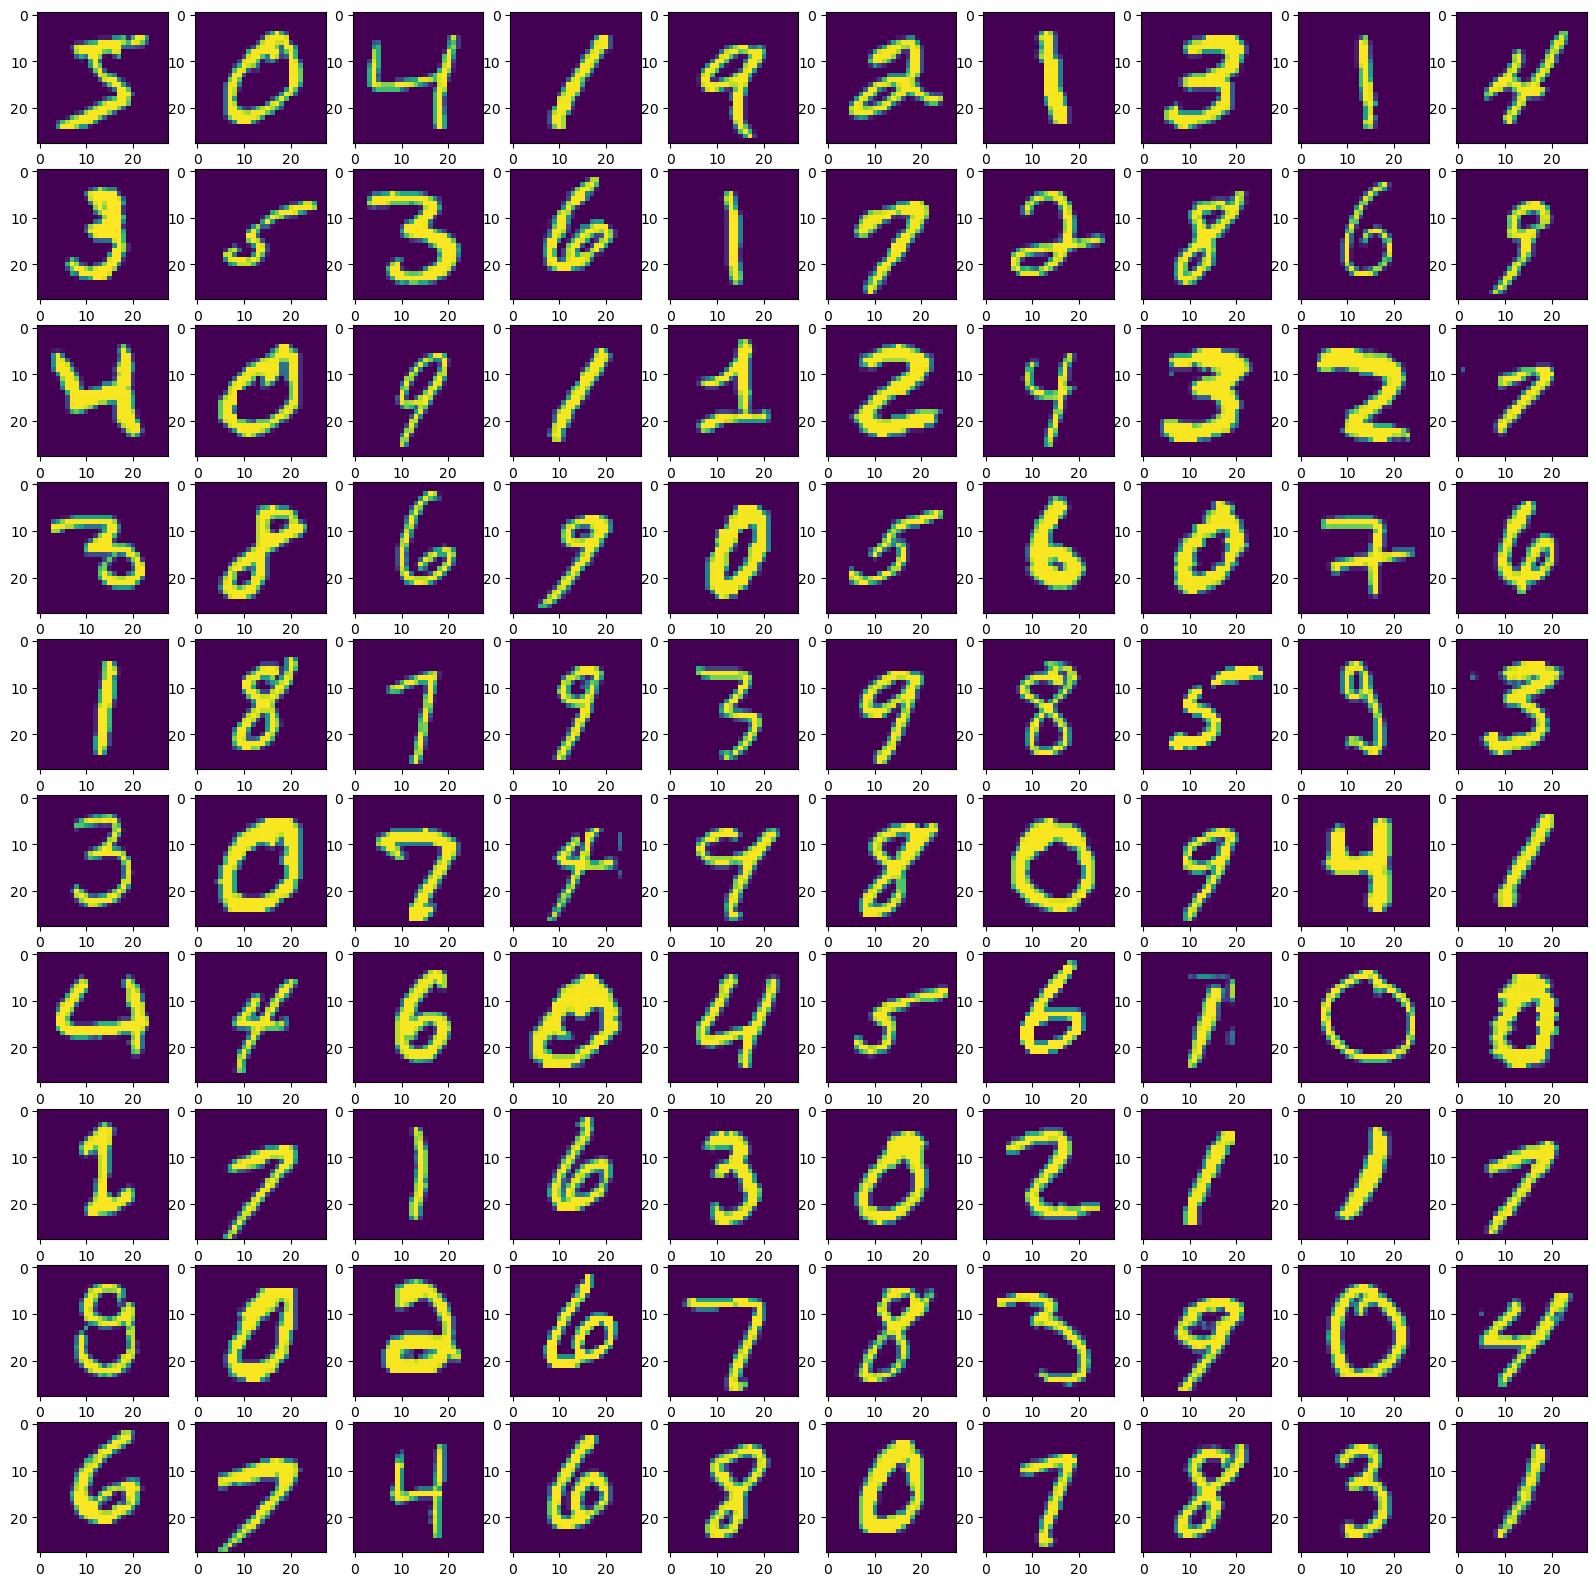

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
fig = plt.figure(figsize=[20, 20])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_train[i,:])

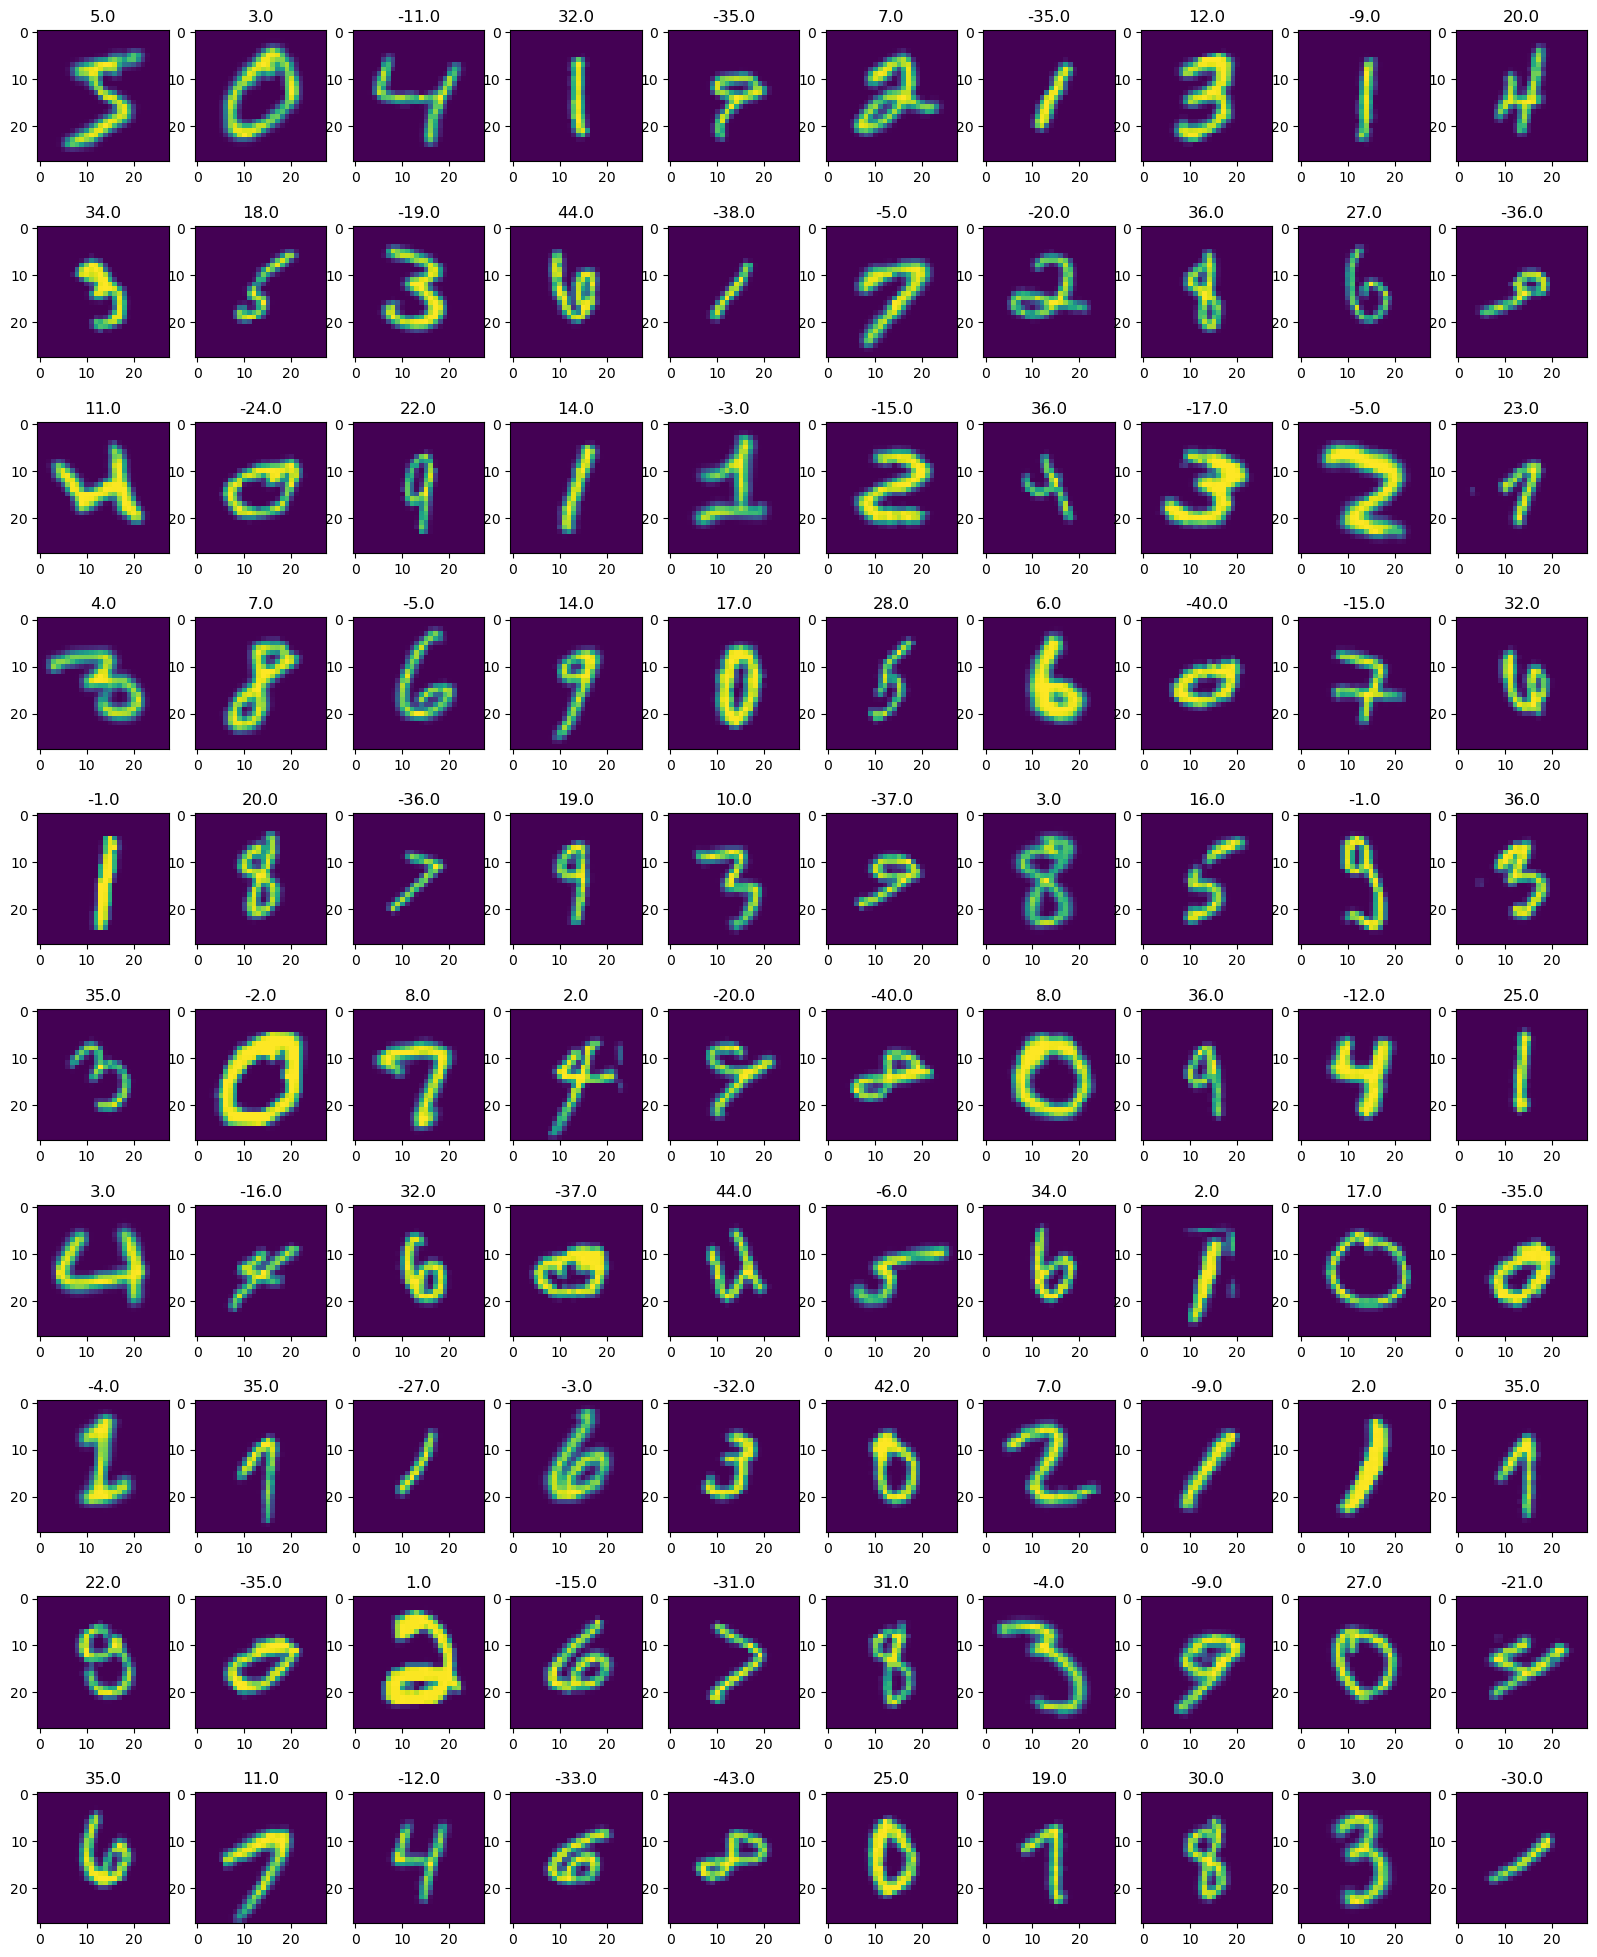

In [4]:
x_train_rot, y_train_rot = rotate_dataset(x_train, 45)
x_train_rot = x_train_rot.reshape(x_train_rot.shape[0], 28, 28, 1).astype('float32')
x_test_rot, y_test_rot = rotate_dataset(x_test, 45)
x_test_rot = x_test_rot.reshape(x_test_rot.shape[0], 28, 28, 1).astype('float32')

fig = plt.figure(figsize=[20, 25])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_train_rot[i, :, :, 0])    
    ax.set_title(str(y_train_rot[i]))

## The Model

We'll pretty much borrow our simple ConvNet from the first example. There are two key differences:
* our output, which is now a single value
* our activations, which are now 'swish' rather than 'relu'

This first change is a result of what we want out network to do: regress to a single value rather than classify an input into one of 10 classes.

The second change is really just here for illustration purposes, but nonetheless is worth discussing. We commonly use a relu activation (rectified linear unit) after our layers and this is effectively the default option. However there are a number of other options, most of which are fairly similar to a relu, but subtly different. Swish is a recent activation that has some nice properties in comparison to a relu, in particular that it leads to a smoother error surface which helps gradient descent. We'll use that in place of relu, just to illustrate how easy it is to change this.

Note that we don't expect this to make a big difference in this case; the most notable differences using swish have been observed for networks with 40+ layers where gradients become harder to propogate, but it won't hurt our performance either.

There are a large number of other activations that could also be used here (leakly relu, elu, softplus), which can all be seen as alternatives to the relu.

In [5]:
# input layer, 28x28x1 images
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
# 3 conv layers, with increasing numbers of filters, and a max-pool in the middle of each pair of Conv's
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='swish')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='swish')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='swish')(x)
# flatten into a vector form so we can pass it through a dense layer
x = layers.Flatten()(x)
# dense layer
x = layers.Dense(64, activation='swish')(x)
# output layer, single value, as we only have 1 output - the 
outputs = layers.Dense(1)(x)

# build the model and print a summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='mnist_angles_cnn_model')
model_cnn.summary()

Model: "mnist_angles_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ img (InputLayer)                │ (None, 28, 28, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 8)         │         80 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 16)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 32)          │      4,640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 288)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 64)                │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 1)                 │         65 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 24,449 (95.50 KB)

 Trainable params: 24,449 (95.50 KB)

 Non-trainable params: 0 (0.00 B)

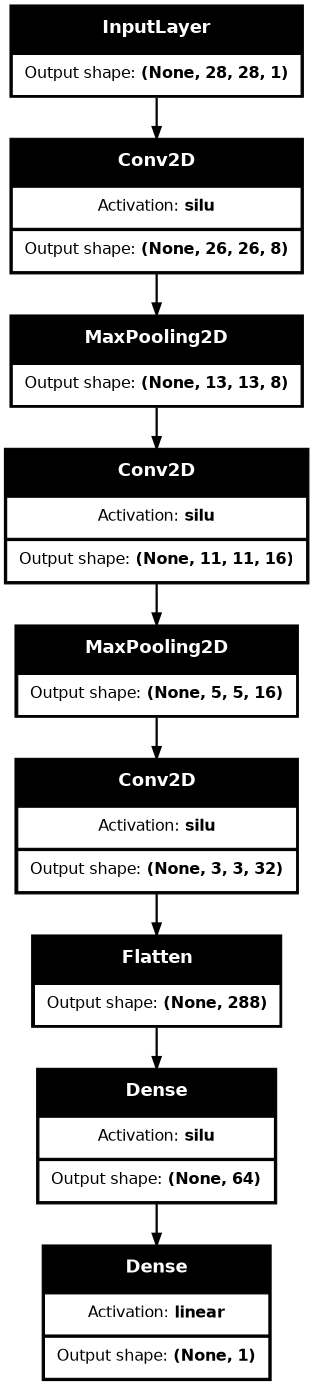

In [6]:
keras.utils.plot_model(model_cnn, show_shapes=True, dpi=80, show_layer_activations=True)

Now for the model training. Here's our next difference compared to what we had for classification: our loss function. We'll use Mean Squared Error here, which simply means that our network will try to minimise the squared difference between the predicted and true values.

In [7]:
# train the model
model_cnn.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(), jit_compile=False)

history = model_cnn.fit(x_train_rot, y_train_rot,
                    batch_size=64,
                    epochs=20,
                    validation_data=(x_test_rot, y_test_rot))

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 368.2462 - val_loss: 149.9967
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 152.6633 - val_loss: 139.9520
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 117.3212 - val_loss: 97.7900
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 102.3706 - val_loss: 90.2128
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 92.4375 - val_loss: 86.2150
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 85.9208 - val_loss: 80.6723
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 80.9978 - val_loss: 75.3541
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 78.0237 - val_loss: 75.3705
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 75.1374 - val_loss: 72.3036
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 71.5712 - val_loss: 68.7030
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 68.3073 - val_loss: 67.5452
Epoch 12/20
938/938 ━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step


/tmp/ipykernel_158/2989528503.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.set_title('P: ' + '%1.2f' % predictions[i] + '; A:' + '%1.2f' % y_test_rot[i])


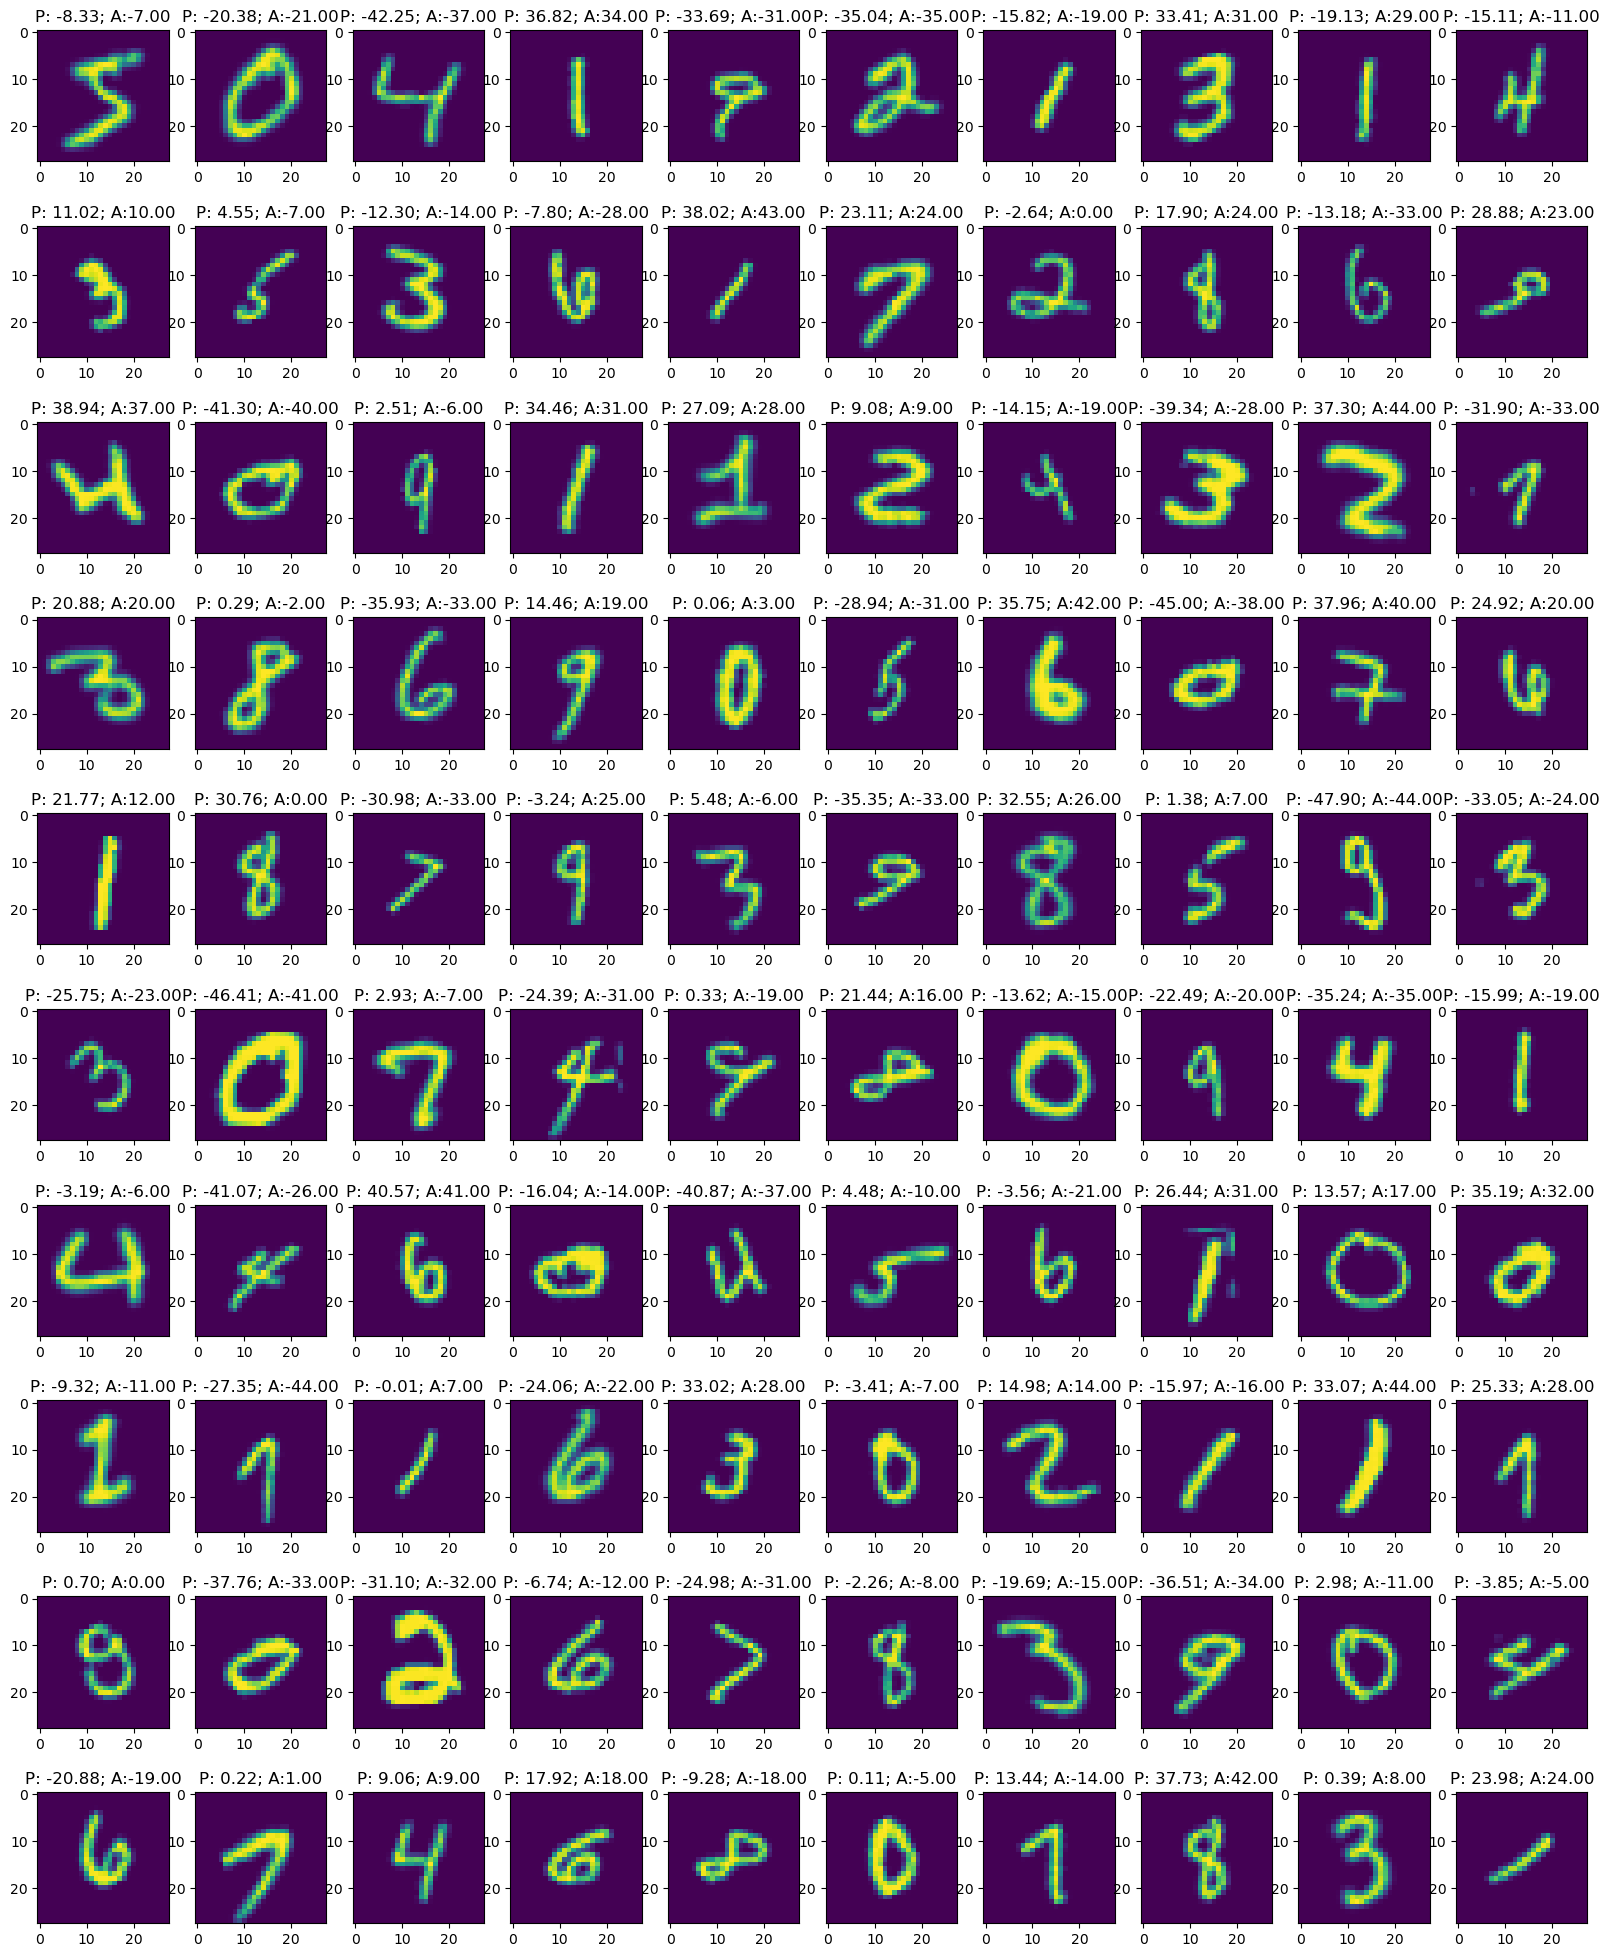

In [8]:
predictions = model_cnn.predict(x_test_rot)
fig = plt.figure(figsize=[20, 25])
for i in range(100):
    ax = fig.add_subplot(10, 10, i + 1)
    ax.imshow(x_train_rot[i, :, :, 0])
    ax.set_title('P: ' + '%1.2f' % predictions[i] + '; A:' + '%1.2f' % y_test_rot[i])

Looking at the predictions, our model does pretty well. It's not perfect, but for the most part it's making a reasonable estimate.

We can also visualise our results as a box plot, looking at the error distribution for each digit. Unsurprisingly, we see larger errors for the digit 0, which makes sense as it's harder to determine the true orientation of what is essentially a circle.

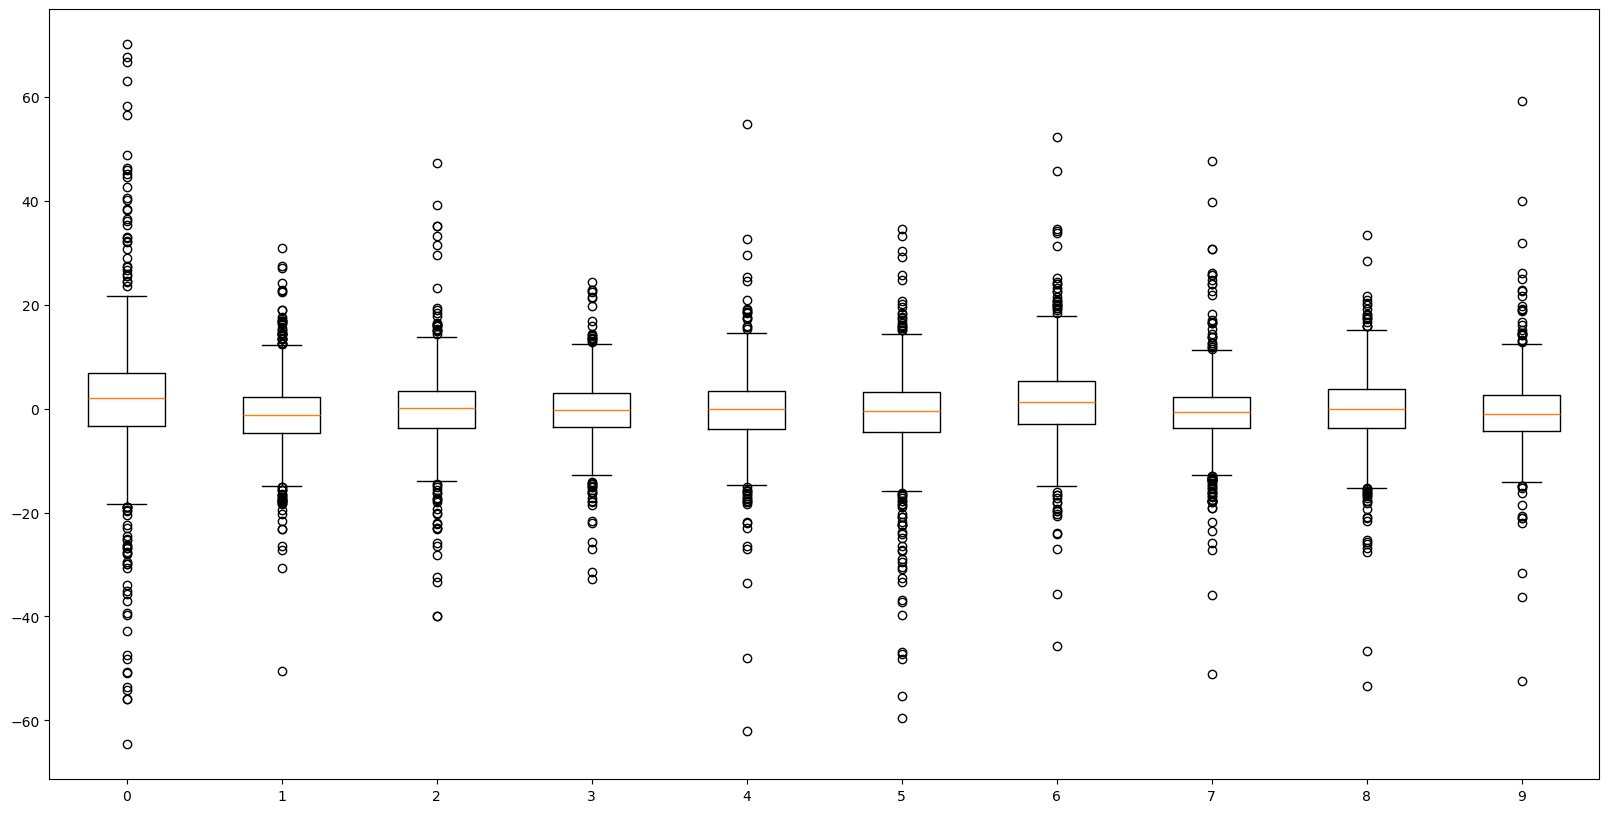

In [9]:
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(1, 1, 1)
data = []
labels = []
for i in range(10):
    sample_idx = numpy.array(y_test == i)
    errors = numpy.subtract(predictions[sample_idx, 0], y_test_rot[sample_idx])
    data.append(errors)
    labels.append(str(i))
    
ax.boxplot(data, labels=labels);

We have a lot of other options with respect to the loss function too. A simple change is to use the Mean Absolute Error rather than MSE. All we do is change the name in the loss when we compile the model.

In [10]:
# input layer, 28x28x1 images
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
# 3 conv layers, with increasing numbers of filters, and a max-pool in the middle of each pair of Conv's
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='swish')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='swish')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='swish')(x)
# flatten into a vector form so we can pass it through a dense layer
x = layers.Flatten()(x)
# dense layer
x = layers.Dense(64, activation='swish')(x)
# output layer, single value, as we only have 1 output - the 
outputs = layers.Dense(1)(x)

# build the model and print a summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='mnist_angles_cnn_model')
# train the model, note we're now using a different loss
model_cnn.compile(loss='mean_absolute_error',
              optimizer=keras.optimizers.Adam(), jit_compile=False)

history = model_cnn.fit(x_train_rot, y_train_rot,
                    batch_size=64,
                    epochs=20,
                    validation_data=(x_test_rot, y_test_rot))

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 15.3291 - val_loss: 8.6152
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.5959 - val_loss: 7.4226
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.3962 - val_loss: 6.7846
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.9179 - val_loss: 6.7447
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.5470 - val_loss: 6.2226
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.2989 - val_loss: 5.8485
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.0446 - val_loss: 5.8263
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.8816 - val_loss: 5.5607
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.6747 - val_loss: 5.6028
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.6181 - val_loss: 5.5045
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.4394 - val_loss: 5.3432
Epoch 12/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/ste

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step


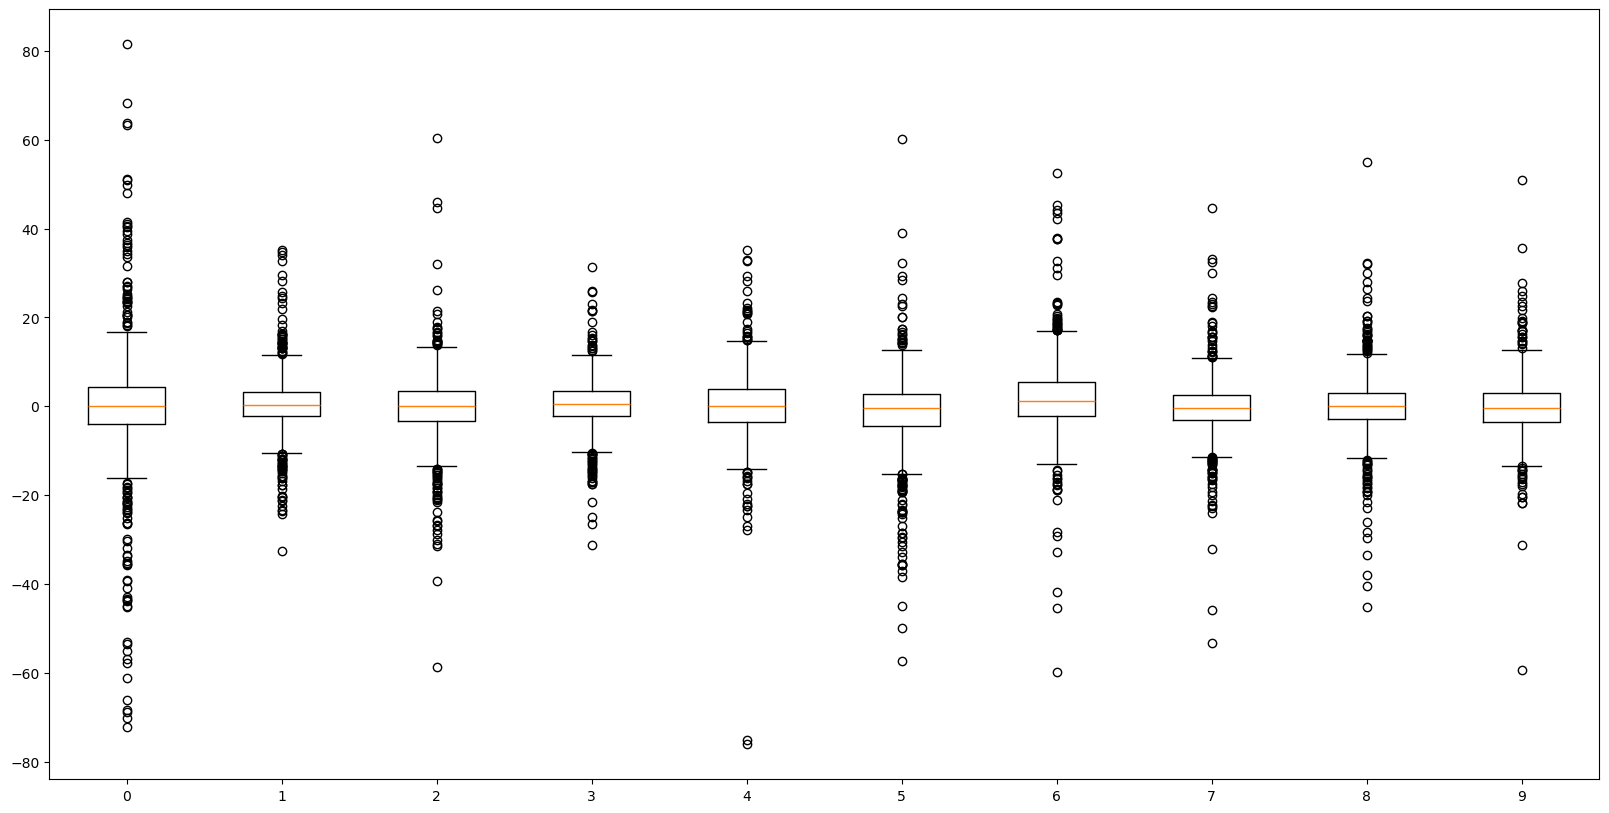

In [11]:
predictions = model_cnn.predict(x_test_rot)
fig = plt.figure(figsize=[20, 10])
ax = fig.add_subplot(1, 1, 1)
data = []
labels = []
for i in range(10):
    sample_idx = numpy.array(y_test == i)
    errors = numpy.subtract(predictions[sample_idx, 0], y_test_rot[sample_idx])
    data.append(errors)
    labels.append(str(i))
    
ax.boxplot(data, labels=labels);

We can see our performance is about the same as we had last time. In this case our choice of loss function doesn't make a huge different, but other times it will.

## Perverse Uses of Regression

Falling into the realm of "because we can", we'll regress to the digit rather than classifiying it.

We'll keep the same network, and we had before and just change back to using the mean squared error.

In [12]:
# input layer, 28x28x1 images
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
# 3 conv layers, with increasing numbers of filters, and a max-pool in the middle of each pair of Conv's
x = layers.Conv2D(filters=8, kernel_size=(3,3), activation='swish')(inputs)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='swish')(x)
x = layers.MaxPool2D(pool_size=(2, 2))(x)
x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='swish')(x)
# flatten into a vector form so we can pass it through a dense layer
x = layers.Flatten()(x)
# dense layer
x = layers.Dense(64, activation='swish')(x)
# output layer, single value, as we only have 1 output - the 
outputs = layers.Dense(1)(x)

# build the model and print a summary
model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='mnist_angles_cnn_model')
# train the model
model_cnn.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(), jit_compile=False)

history = model_cnn.fit(x_train_rot, y_train,
                    batch_size=64,
                    epochs=20,
                    validation_data=(x_test_rot, y_test))

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.4865 - val_loss: 2.7331
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.4826 - val_loss: 1.6023
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.5777 - val_loss: 1.3230
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.1509 - val_loss: 0.9517
Epoch 5/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9273 - val_loss: 0.8526
Epoch 6/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.7942 - val_loss: 0.7200
Epoch 7/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6908 - val_loss: 0.6816
Epoch 8/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.6141 - val_loss: 0.6061
Epoch 9/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.5498 - val_loss: 0.5715
Epoch 10/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4824 - val_loss: 0.5362
Epoch 11/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4517 - val_loss: 0.4973
Epoch 12/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step


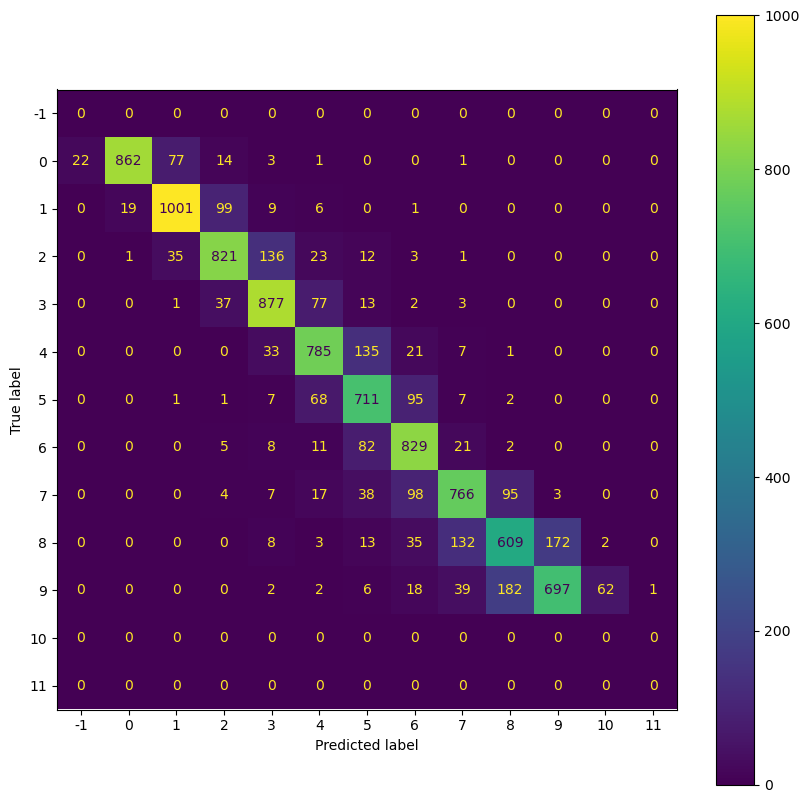

In [13]:
pred = model_cnn.predict(x_test_rot);
pred = numpy.rint(pred)

cm = confusion_matrix(y_test, pred)
fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(1, 1, 1)
c = ConfusionMatrixDisplay(cm, display_labels=range(int(min(pred)[0]), int(max(pred)[0] + 1)))
c.plot(ax = ax);

This actually works ok, but gives us quite a different error distribution to what we may expect if we treated this as a classification task, which is really a result of the loss we're trying to minimise. We're not helped by the fact that we're predicting on the rotated images, which aren't as easy to predict as the upright ones.

While this works ok, it's not really a good approach. Digit classification is a classification task (the hint's in the name), just becuase we can formulate it as regression doesn't mean we should.

## Final Thoughts

In this example:
* We've seen how to use a deep net for regression, and it's pretty similar to how we do classification
* The only real difference is the loss function. For a classification task, we use a categorical or binary cross entropy loss. For regression, we use a loss such as Mean Squared Error.
* We've had a brief look at changing our activation function, and seen that we can do this in a pretty straight foward manner
* Deep nets can give us the freedom to solve our problem in different ways. For example, we can refactor our classification task as regression. Does this make sense here? Perhaps not, but there are other stuations (crowd counting) where such a formulation would.